# Naive Bayes sport

In [1]:
import json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported!")

Libraries imported!


In [2]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', figsize=(14, 10), 
                          cmap='Blues', fontsize_title=16, fontsize_labels=12):
    from sklearn.utils.multiclass import unique_labels
    
    labels = list(unique_labels(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=cmap,
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Number of samples'},
        linewidths=0.5,
        linecolor='gray'
    )
    plt.title(title, fontsize=fontsize_title, pad=20)
    plt.xlabel('Predicted Category', fontsize=fontsize_labels)
    plt.ylabel('Actual Category', fontsize=fontsize_labels)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def display_classification_metrics(y_true, y_pred, model_name='Model'):
    accuracy = accuracy_score(y_true, y_pred) * 100
    
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    results = []
    for label in sorted(report.keys()):
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            results.append({
                'Category': label,
                'Precision': f"{report[label]['precision']:.4f}",
                'Recall': f"{report[label]['recall']:.4f}",
                'F1-Score': f"{report[label]['f1-score']:.4f}"
            })
    
    df = pd.DataFrame(results)
    df['Precision'] = pd.to_numeric(df['Precision'])
    df['Recall'] = pd.to_numeric(df['Recall'])
    df['F1-Score'] = pd.to_numeric(df['F1-Score'])
    
    styled_df = df.style.format({
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1-Score': '{:.4f}'
    }).background_gradient(subset=['Precision', 'Recall', 'F1-Score'], cmap='YlGnBu', vmin=0, vmax=1).set_caption(f'Overall Accuracy: {accuracy:.2f}%').set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
    
    display(styled_df)

In [3]:
file_path = 'sport_url_scraper/selected_articles.json'

with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Number of articles: {len(data)}")

Number of articles: 3042


In [4]:
texts = []
labels = []

for article in data:
    texts.append(article['text'])
    labels.append(article['label'])

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(X_train)} articles")
print(f"Test set: {len(X_test)} articles")
print(f"Categories in training set: {Counter(y_train)}")


Training set: 2433 articles
Test set: 609 articles
Categories in training set: Counter({'rugby-union': 320, 'football': 320, 'formula1': 320, 'cricket': 320, 'boxing': 307, 'rugby-league': 267, 'tennis': 213, 'american-football': 199, 'mixed-martial-arts': 167})


In [5]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(
        lowercase=True,
        token_pattern=r'\b[a-z]+\b',
        min_df=2,
        max_features=10000
    )),
    ('classifier', MultinomialNB(alpha=1.0))
])

classifier.fit(X_train, y_train)

print("✓ Trained!")
print(f"Number of features (words): {len(classifier.named_steps['vectorizer'].vocabulary_)}")


✓ Trained!
Number of features (words): 10000


In [6]:
print("Predicting categories for test set...")
predictions = classifier.predict(X_test)

display_classification_metrics(y_test, predictions)


Predicting categories for test set...


,Category,Precision,Recall,F1-Score
0,american-football,1.0000,1.0000,1.0000
1,boxing,1.0000,1.0000,1.0000
2,cricket,1.0000,1.0000,1.0000
3,football,1.0000,0.9625,0.9809
4,formula1,1.0000,1.0000,1.0000
5,mixed-martial-arts,1.0000,1.0000,1.0000
6,rugby-league,1.0000,0.9851,0.9925
7,rugby-union,0.9524,1.0000,0.9756
8,tennis,1.0000,1.0000,1.0000


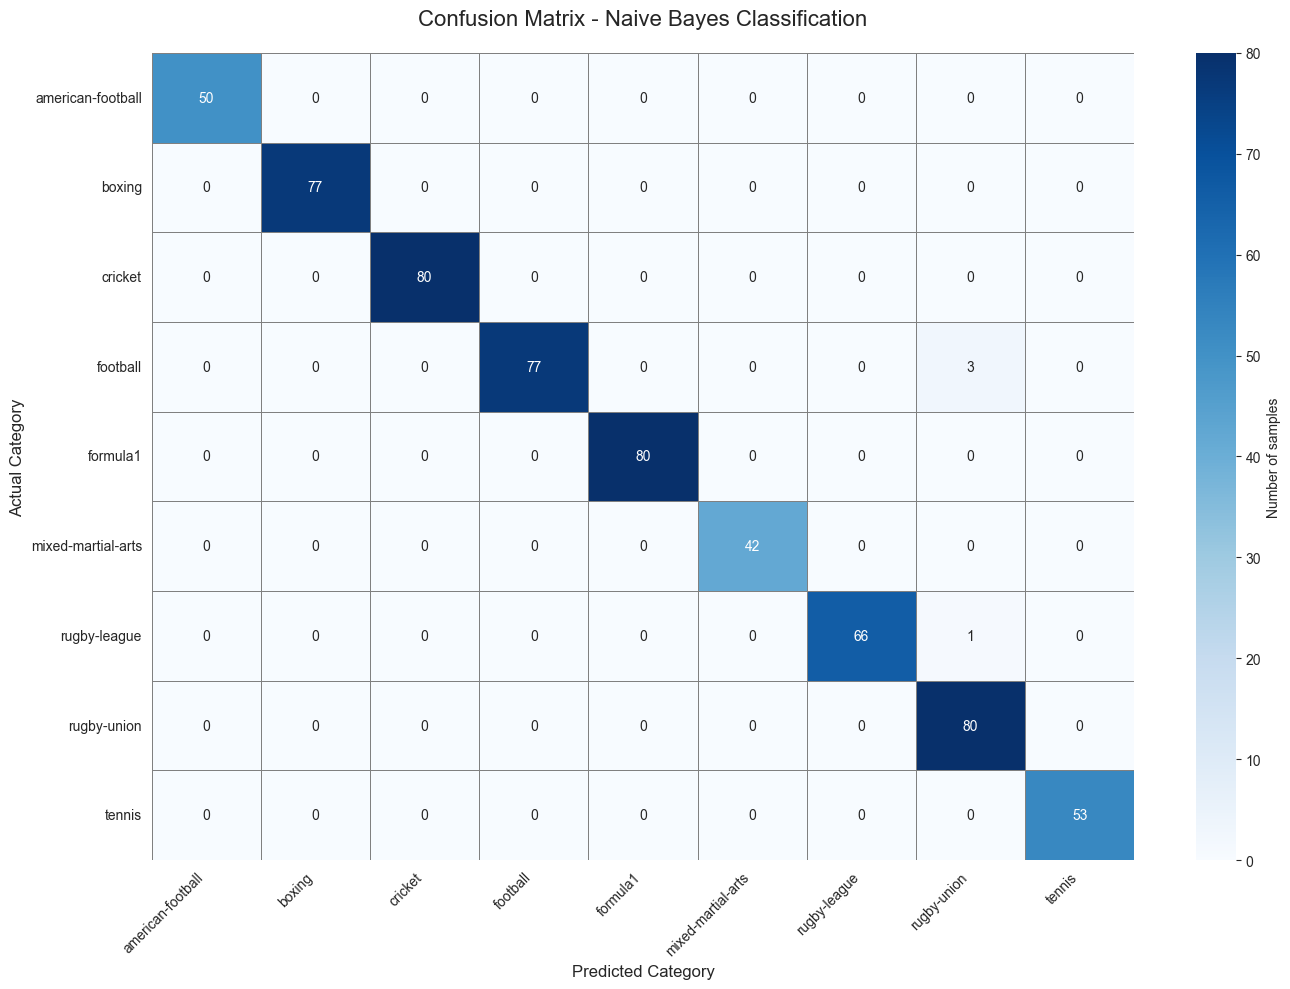

In [ ]:
plot_confusion_matrix(y_test, predictions, title='Confusion Matrix - Naive Bayes Classification')


# LinearSVC


In [8]:
linear_svc_classifier = Pipeline([
    ('vectorizer', CountVectorizer(
        lowercase=True,
        token_pattern=r'\b[a-z]+\b',
        min_df=2,
        max_features=10000
    )),
    ('classifier', LinearSVC(random_state=42, max_iter=1000))
])

linear_svc_classifier.fit(X_train, y_train)

print("✓ Trained!")
print(f"Number of features (words): {len(linear_svc_classifier.named_steps['vectorizer'].vocabulary_)}")


✓ Trained!
Number of features (words): 10000


c:\Users\Krzysztof\Desktop\DataMining\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [9]:
svc_predictions = linear_svc_classifier.predict(X_test)

display_classification_metrics(y_test, svc_predictions)


,Category,Precision,Recall,F1-Score
0,american-football,1.0000,1.0000,1.0000
1,boxing,0.9872,1.0000,0.9935
2,cricket,0.9877,1.0000,0.9938
3,football,0.9630,0.9750,0.9689
4,formula1,1.0000,1.0000,1.0000
5,mixed-martial-arts,1.0000,0.9524,0.9756
6,rugby-league,1.0000,0.9701,0.9848
7,rugby-union,0.9634,0.9875,0.9753
8,tennis,1.0000,0.9811,0.9905


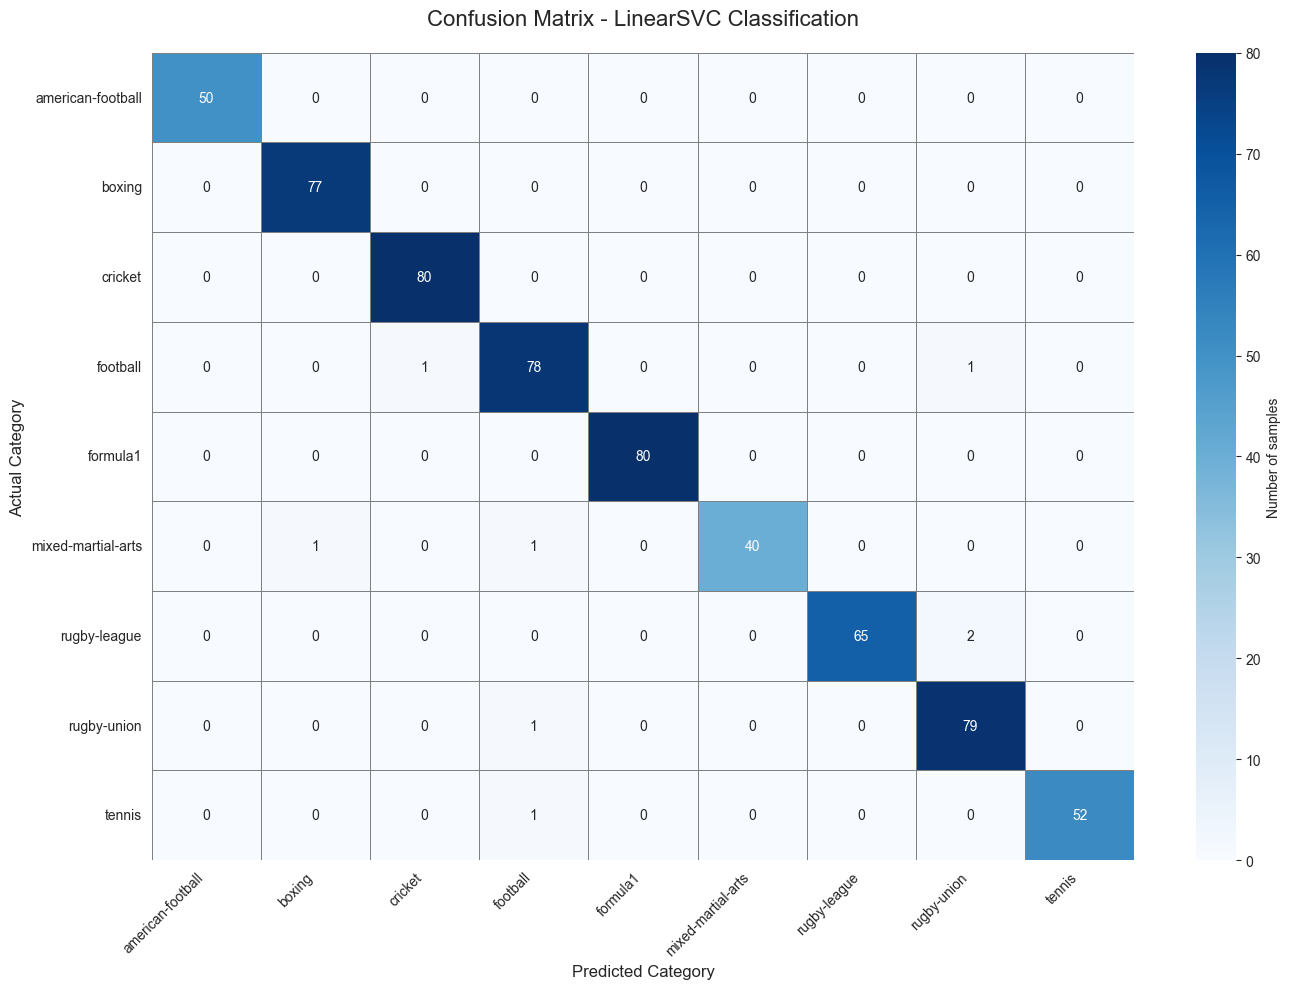

In [10]:
plot_confusion_matrix(y_test, svc_predictions, title='Confusion Matrix - LinearSVC Classification')

# CNN (Conv1D) 


In [11]:
print("="*80)
print("CNN (CONV1D) CLASSIFIER FOR TEXT")
print("="*80)
print("\nPreparing data for CNN...")

max_words = 10000
max_len = 500

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(np.unique(y_train_encoded))
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

print(f"Vocabulary size: {max_words}")
print(f"Sequence length: {max_len}")
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(X_train_padded)}")
print(f"Test samples: {len(X_test_padded)}")


CNN (CONV1D) CLASSIFIER FOR TEXT

Preparing data for CNN...
Vocabulary size: 10000
Sequence length: 500
Number of classes: 9
Training samples: 2433
Test samples: 609


In [12]:
embedding_dim = 128

cnn_model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


c:\Users\Krzysztof\Desktop\DataMining\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
print("\nTraining CNN classifier...")

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = cnn_model.fit(
    X_train_padded, y_train_categorical,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("✓ Trained!")



Training CNN classifier...
Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.2307 - loss: 2.1202 - val_accuracy: 0.4805 - val_loss: 1.8919
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6280 - loss: 1.2729 - val_accuracy: 0.8172 - val_loss: 0.6375
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8828 - loss: 0.4291 - val_accuracy: 0.9446 - val_loss: 0.2452
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9563 - loss: 0.1890 - val_accuracy: 0.9569 - val_loss: 0.1648
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9723 - loss: 0.1148 - val_accuracy: 0.9754 - val_loss: 0.1185
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9887 - loss: 0.0682 - val_accuracy: 0.9836 - val_loss: 0.1011
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9943 - loss: 0.0467 - val_accuracy: 0.9815 - val_loss: 0.0881
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9923 - loss: 0.040

In [14]:
cnn_predictions_proba = cnn_model.predict(X_test_padded, verbose=0)
cnn_predictions_encoded = np.argmax(cnn_predictions_proba, axis=1)
cnn_predictions = label_encoder.inverse_transform(cnn_predictions_encoded)

display_classification_metrics(y_test, cnn_predictions)


,Category,Precision,Recall,F1-Score
0,american-football,0.9608,0.9800,0.9703
1,boxing,0.9615,0.9740,0.9677
2,cricket,0.9753,0.9875,0.9814
3,football,0.9753,0.9875,0.9814
4,formula1,1.0000,0.9875,0.9937
5,mixed-martial-arts,0.9318,0.9762,0.9535
6,rugby-league,0.9701,0.9701,0.9701
7,rugby-union,0.9737,0.9250,0.9487
8,tennis,0.9808,0.9623,0.9714


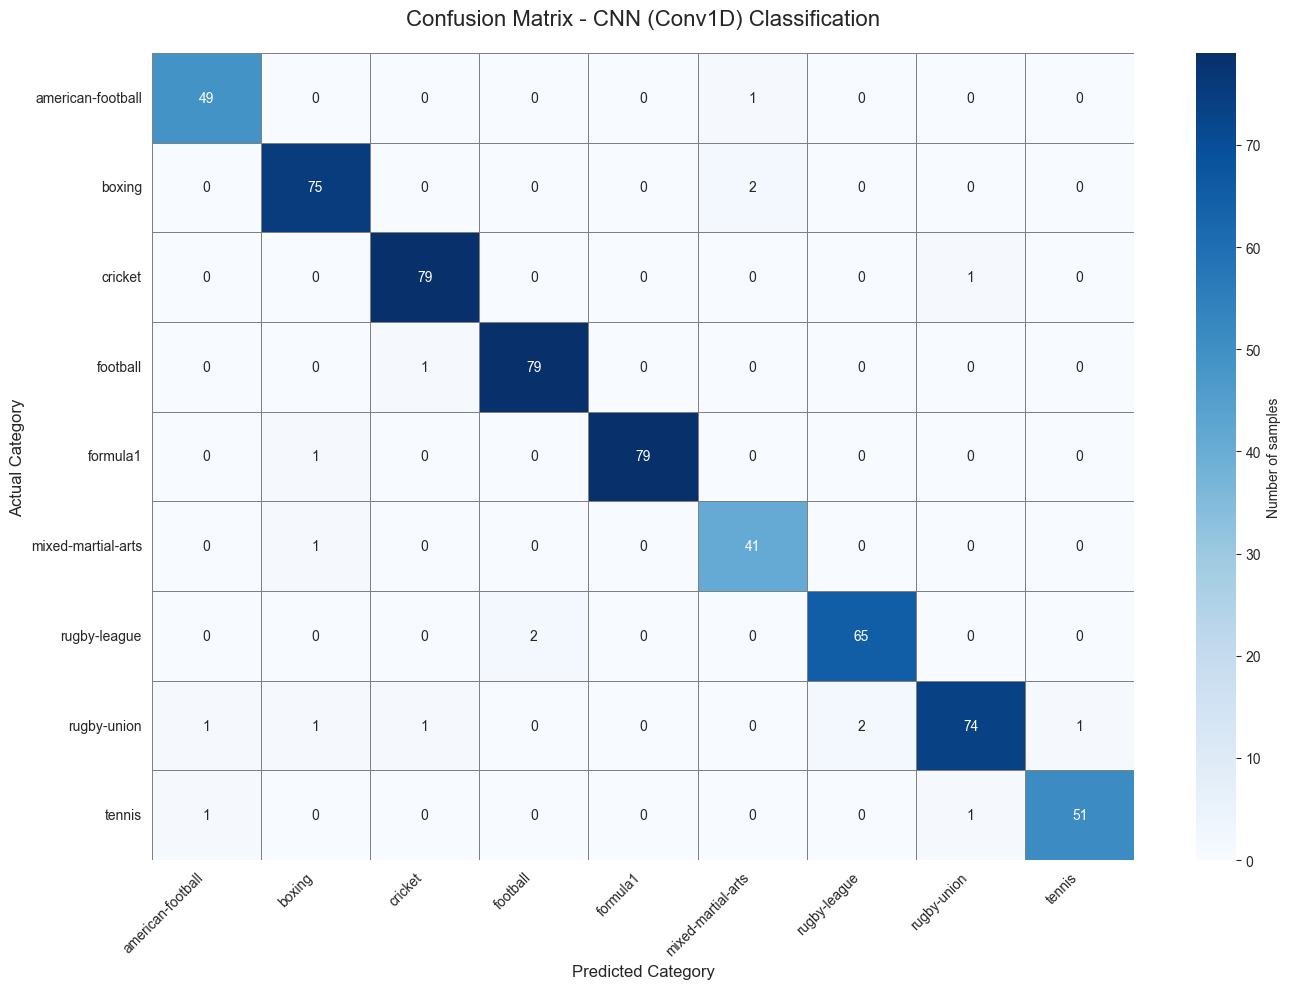

In [15]:
plot_confusion_matrix(y_test, cnn_predictions, title='Confusion Matrix - CNN (Conv1D) Classification')


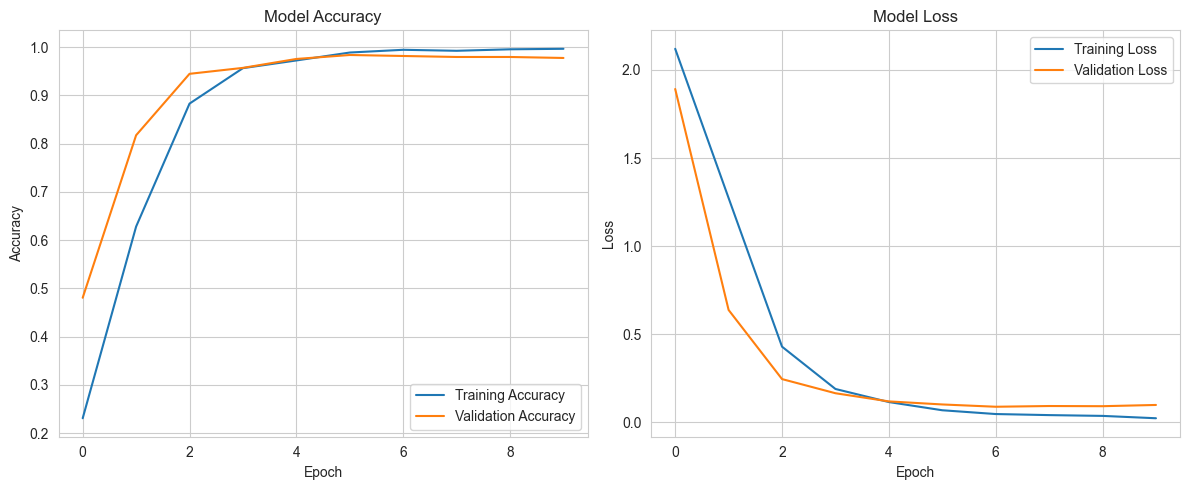

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Word Importance Analysis


In [17]:
print("="*80)
print("WORD IMPORTANCE ANALYSIS - NAIVE BAYES")
print("="*80)

vectorizer = classifier.named_steps['vectorizer']
nb_model = classifier.named_steps['classifier']
vocabulary = vectorizer.vocabulary_
feature_names = vectorizer.get_feature_names_out()

feature_log_prob = nb_model.feature_log_prob_
classes = nb_model.classes_

print(f"\nNumber of categories: {len(classes)}")
print(f"Number of words (features): {len(feature_names)}")

nb_top_words = {}
for i, category in enumerate(classes):
    other_categories_log_probs = np.mean(
        np.delete(feature_log_prob, i, axis=0), 
        axis=0
    )
    
    discriminative_scores = feature_log_prob[i] - other_categories_log_probs
    
    top_indices = np.argsort(discriminative_scores)[::-1][:3]
    top_words = [(feature_names[idx], discriminative_scores[idx]) for idx in top_indices]
    nb_top_words[category] = top_words

print("\n" + "="*80)
print("TOP 3 WORDS FOR EACH CATEGORY (Naive Bayes - discriminative measure):")
print("="*80)
for category in sorted(nb_top_words.keys()):
    print(f"\n{category.upper()}:")
    for word, score in nb_top_words[category]:
        print(f"  - {word:20s} (discriminative score: {score:.4f})")


WORD IMPORTANCE ANALYSIS - NAIVE BAYES

Number of categories: 9
Number of words (features): 10000

TOP 3 WORDS FOR EACH CATEGORY (Naive Bayes - discriminative measure):

AMERICAN-FOOTBALL:
  - quarterback          (discriminative score: 5.9692)
  - nfl                  (discriminative score: 5.8390)
  - chiefs               (discriminative score: 5.4900)

BOXING:
  - usyk                 (discriminative score: 6.2026)
  - dubois               (discriminative score: 5.9128)
  - fury                 (discriminative score: 5.5361)

CRICKET:
  - wickets              (discriminative score: 5.8186)
  - wicket               (discriminative score: 5.3980)
  - cricket              (discriminative score: 5.3960)

FOOTBALL:
  - midfielder           (discriminative score: 5.0506)
  - rangers              (discriminative score: 4.6800)
  - arsenal              (discriminative score: 4.6066)

FORMULA1:
  - verstappen           (discriminative score: 6.5139)
  - norris               (discriminative s

In [18]:
print("="*80)
print("WORD IMPORTANCE ANALYSIS - LINEAR SVC")
print("="*80)

svc_vectorizer = linear_svc_classifier.named_steps['vectorizer']
svc_model = linear_svc_classifier.named_steps['classifier']
svc_feature_names = svc_vectorizer.get_feature_names_out()

svc_coef = svc_model.coef_
svc_classes = svc_model.classes_

print(f"\nNumber of categories: {len(svc_classes)}")
print(f"Number of words (features): {len(svc_feature_names)}")

svc_top_words = {}
for i, category in enumerate(svc_classes):
    coefs = svc_coef[i]
    top_indices = np.argsort(coefs)[::-1][:3]
    top_words = [(svc_feature_names[idx], coefs[idx]) for idx in top_indices]
    svc_top_words[category] = top_words

print("\n" + "="*80)
print("TOP 3 WORDS FOR EACH CATEGORY (LinearSVC):")
print("="*80)
for category in sorted(svc_top_words.keys()):
    print(f"\n{category.upper()}:")
    for word, score in svc_top_words[category]:
        print(f"  - {word:20s} (coefficient: {score:.4f})")


WORD IMPORTANCE ANALYSIS - LINEAR SVC

Number of categories: 9
Number of words (features): 10000

TOP 3 WORDS FOR EACH CATEGORY (LinearSVC):

AMERICAN-FOOTBALL:
  - nfl                  (coefficient: 0.2645)
  - bowl                 (coefficient: 0.1647)
  - field                (coefficient: 0.0974)

BOXING:
  - boxing               (coefficient: 0.1634)
  - fight                (coefficient: 0.1027)
  - world                (coefficient: 0.0906)

CRICKET:
  - cricket              (coefficient: 0.2721)
  - county               (coefficient: 0.1808)
  - wickets              (coefficient: 0.1600)

FOOTBALL:
  - use                  (coefficient: 0.1772)
  - football             (coefficient: 0.1755)
  - manager              (coefficient: 0.1737)

FORMULA1:
  - prix                 (coefficient: 0.1831)
  - formula              (coefficient: 0.1680)
  - race                 (coefficient: 0.1481)

MIXED-MARTIAL-ARTS:
  - ufc                  (coefficient: 0.2626)
  - mma                  

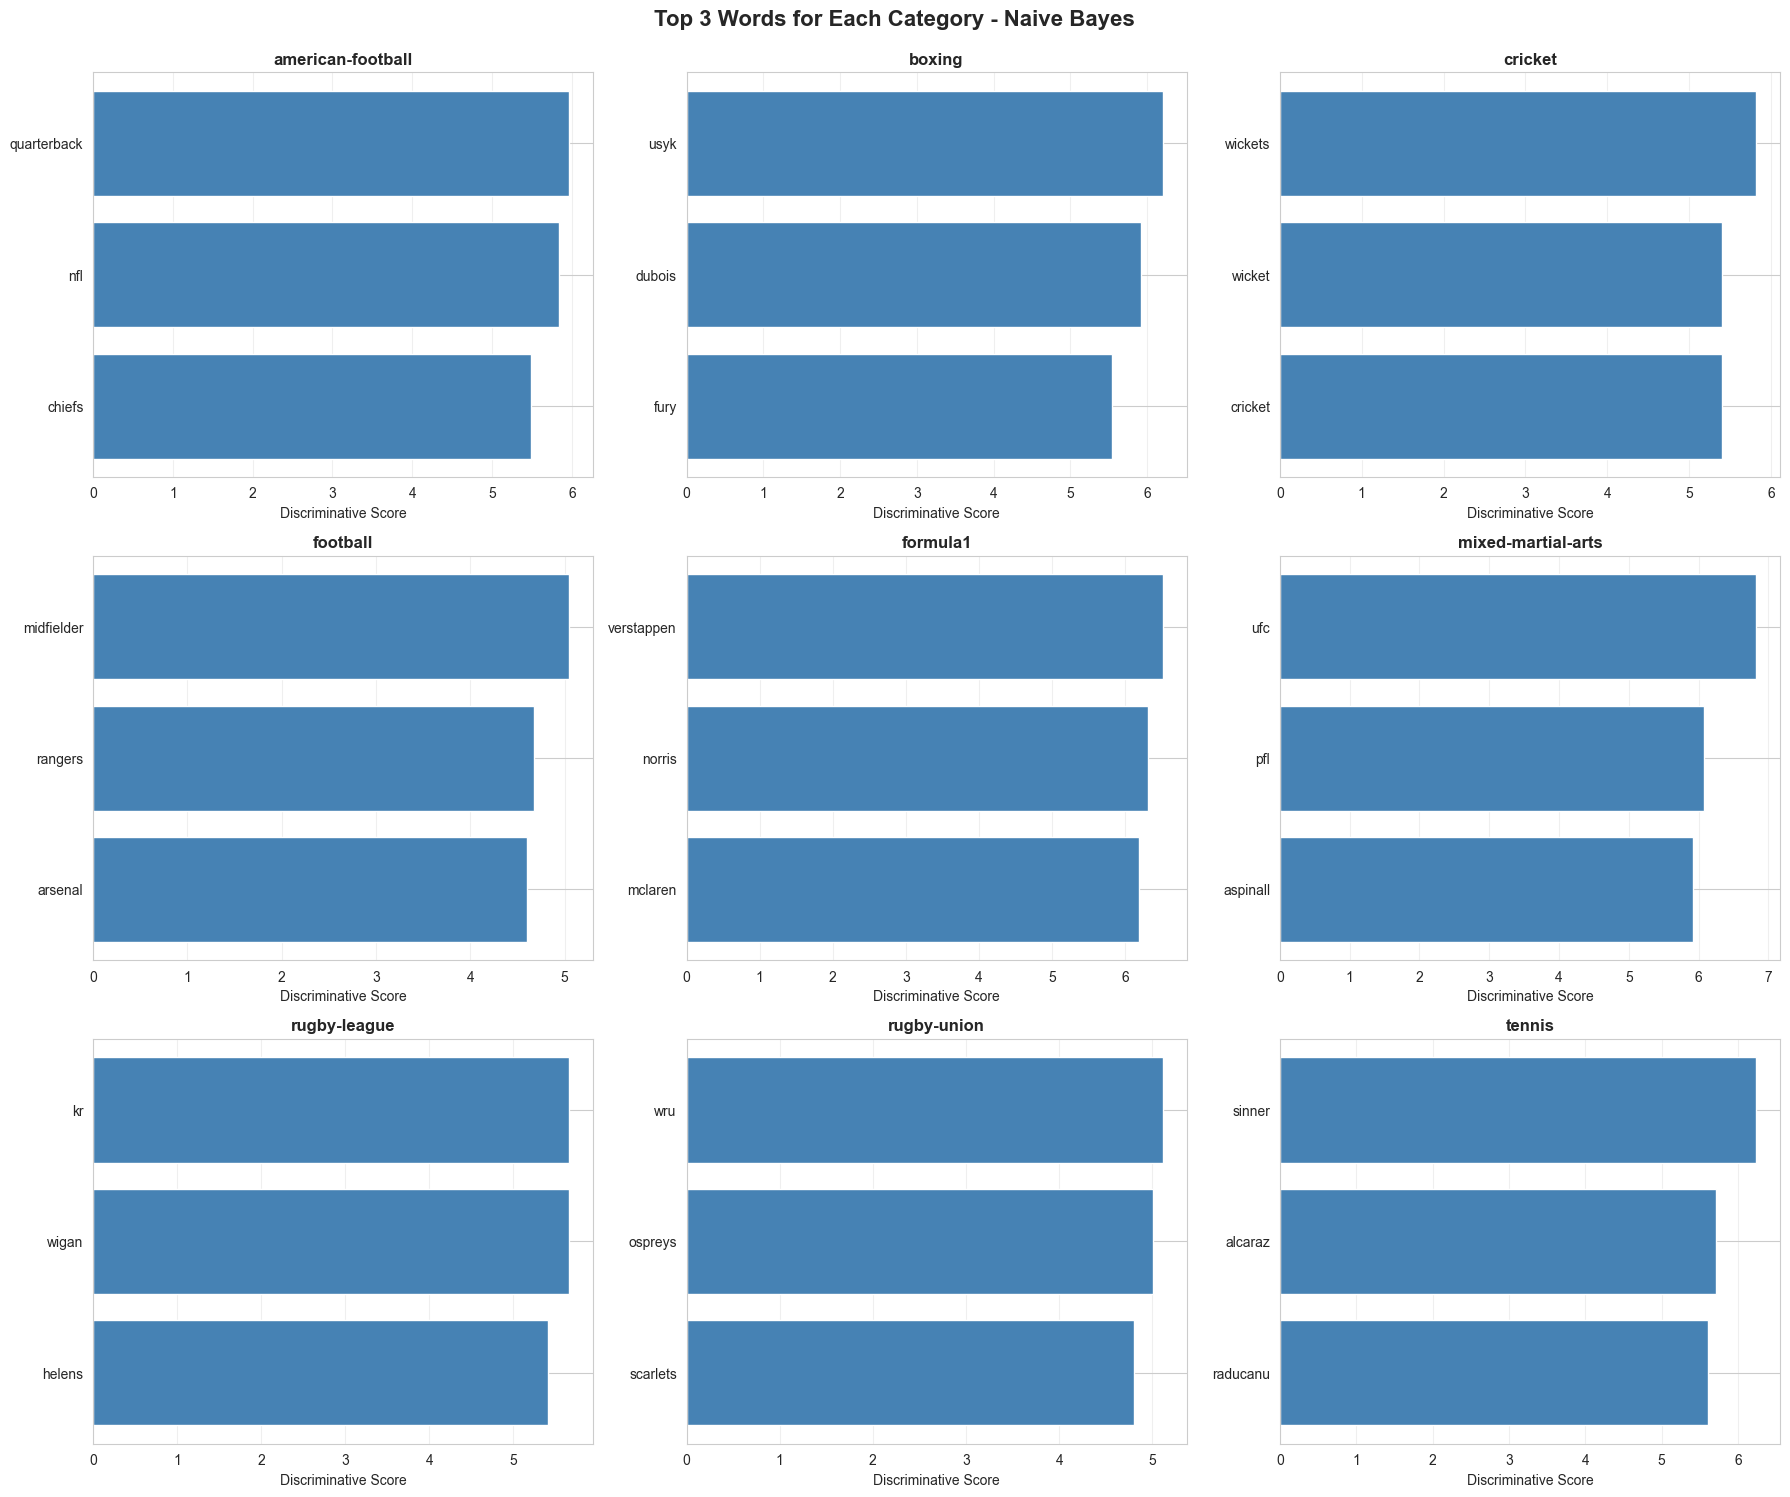

In [19]:
nb_vis_data = []
for category in sorted(nb_top_words.keys()):
    for word, score in nb_top_words[category]:
        nb_vis_data.append({
            'Category': category,
            'Word': word,
            'Score': score,
            'Model': 'Naive Bayes'
        })

nb_vis_df = pd.DataFrame(nb_vis_data)

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

categories = sorted(nb_top_words.keys())
for idx, category in enumerate(categories):
    cat_data = nb_vis_df[nb_vis_df['Category'] == category].sort_values('Score', ascending=True)
    
    axes[idx].barh(cat_data['Word'], cat_data['Score'], color='steelblue')
    axes[idx].set_title(f'{category}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Discriminative Score', fontsize=10)
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Top 3 Words for Each Category - Naive Bayes', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


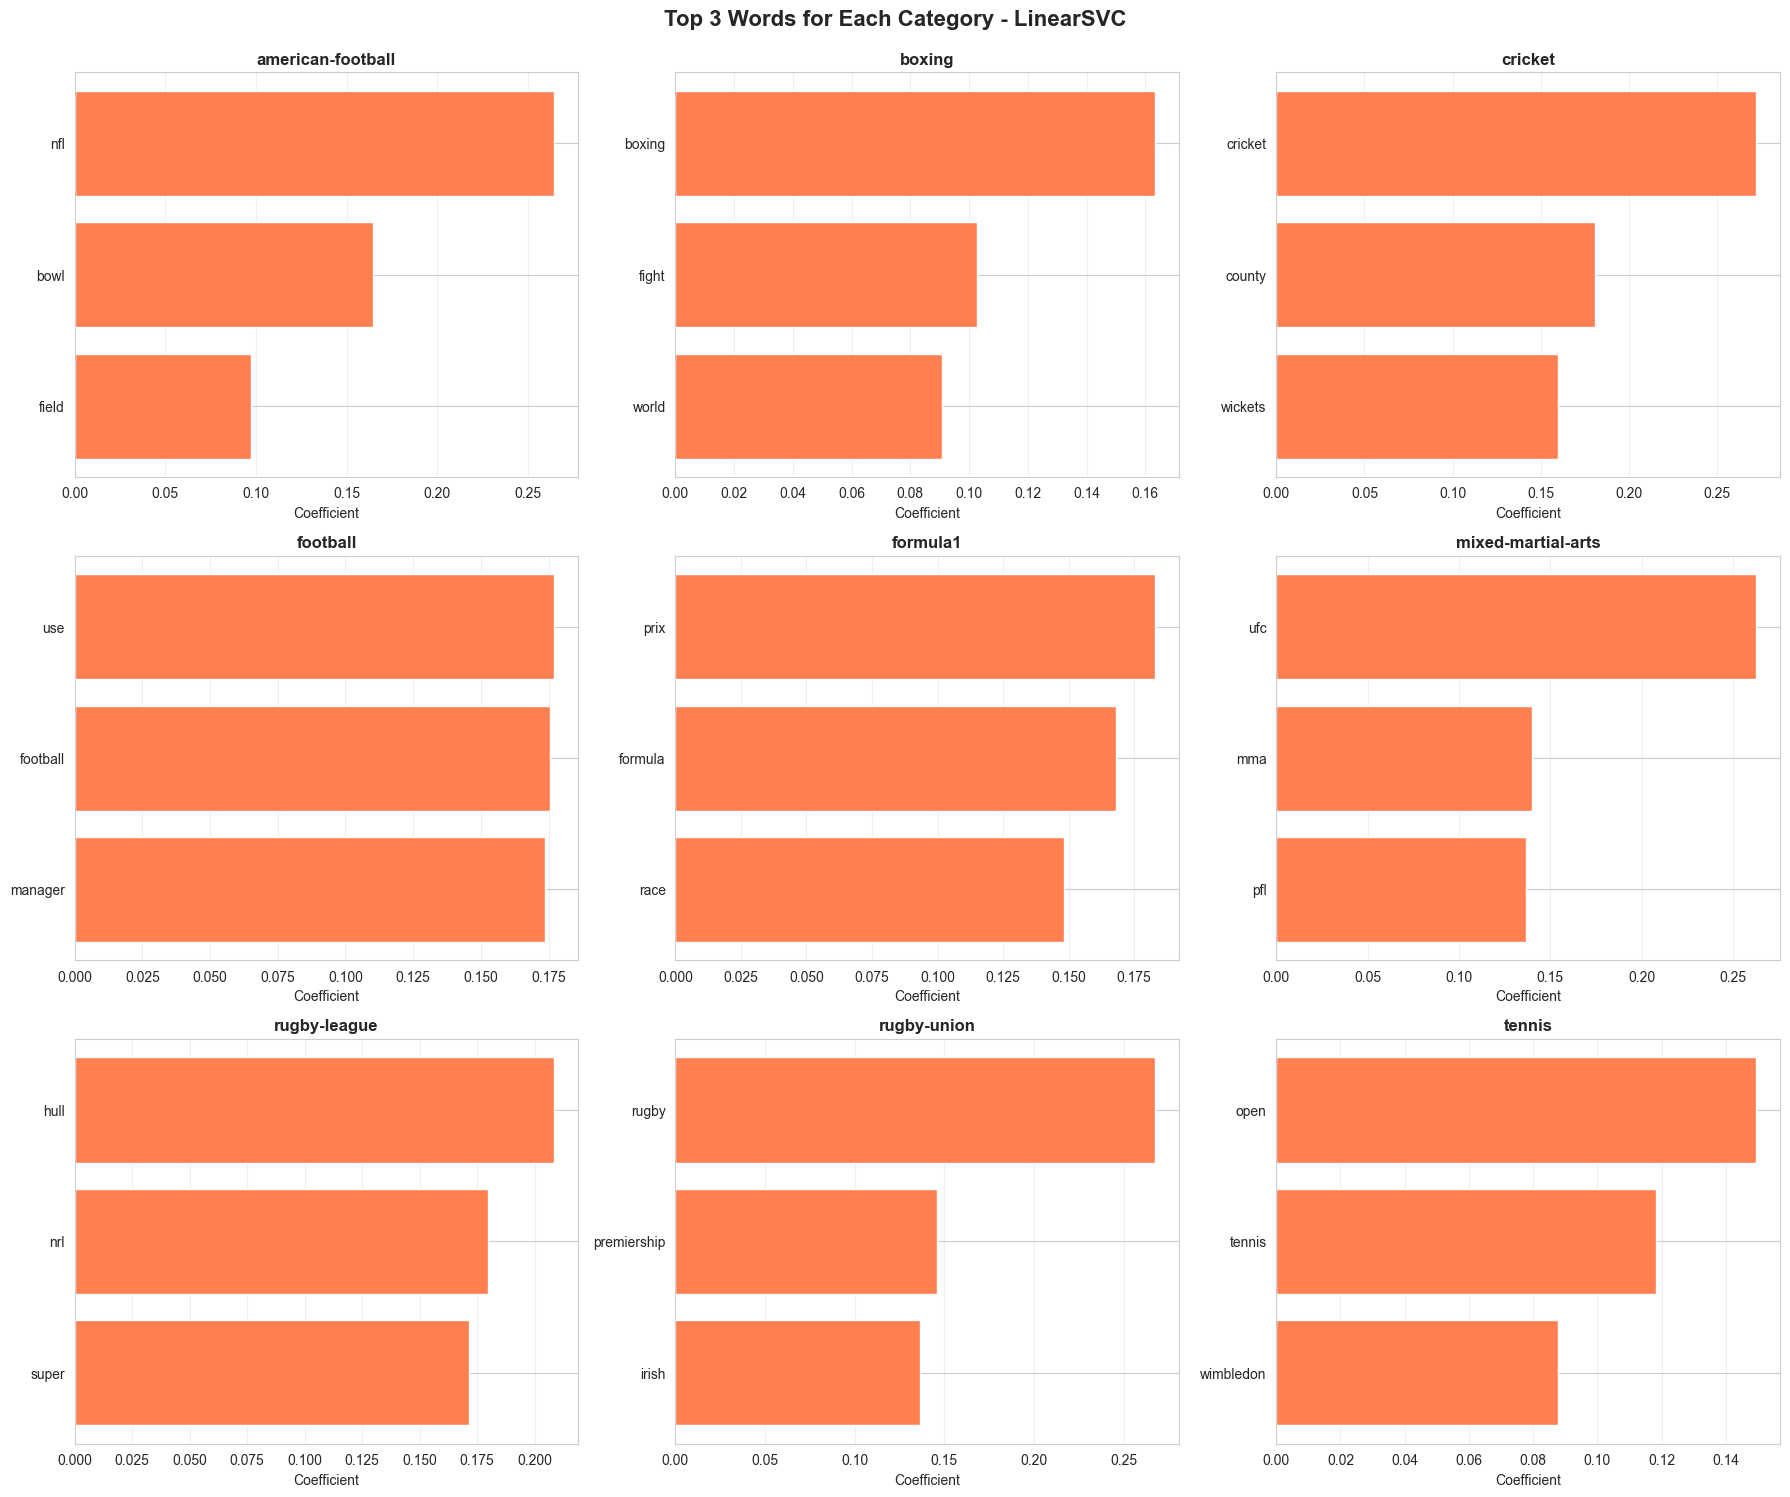

In [20]:
svc_vis_data = []
for category in sorted(svc_top_words.keys()):
    for word, score in svc_top_words[category]:
        svc_vis_data.append({
            'Category': category,
            'Word': word,
            'Score': score,
            'Model': 'LinearSVC'
        })

svc_vis_df = pd.DataFrame(svc_vis_data)


fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

categories = sorted(svc_top_words.keys())
for idx, category in enumerate(categories):
    cat_data = svc_vis_df[svc_vis_df['Category'] == category].sort_values('Score', ascending=True)
    
    axes[idx].barh(cat_data['Word'], cat_data['Score'], color='coral')
    axes[idx].set_title(f'{category}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Coefficient', fontsize=10)
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Top 3 Words for Each Category - LinearSVC', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [21]:
comparison_data = []
for category in sorted(set(list(nb_top_words.keys()) + list(svc_top_words.keys()))):
    nb_words = [w[0] for w in nb_top_words.get(category, [])]
    svc_words = [w[0] for w in svc_top_words.get(category, [])]
    
    comparison_data.append({
        'Category': category,
        'Naive Bayes - Top 3': ', '.join(nb_words) if nb_words else 'N/A',
        'LinearSVC - Top 3': ', '.join(svc_words) if svc_words else 'N/A',
        'Common Words': ', '.join(set(nb_words) & set(svc_words)) if (nb_words and svc_words) else 'None'
    })

comparison_df = pd.DataFrame(comparison_data)

styled_comparison = comparison_df.style.set_caption('Top 3 Words Comparison Between Models').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '14px'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'th', 'props': [('background-color', '#4472C4'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'left'), ('padding', '8px')]}
]).set_properties(subset=['Category'], **{'font-weight': 'bold'})

display(styled_comparison)


,Category,Naive Bayes - Top 3,LinearSVC - Top 3,Common Words
0,american-football,"quarterback, nfl, chiefs","nfl, bowl, field",nfl
1,boxing,"usyk, dubois, fury","boxing, fight, world",
2,cricket,"wickets, wicket, cricket","cricket, county, wickets","cricket, wickets"
3,football,"midfielder, rangers, arsenal","use, football, manager",
4,formula1,"verstappen, norris, mclaren","prix, formula, race",
5,mixed-martial-arts,"ufc, pfl, aspinall","ufc, mma, pfl","pfl, ufc"
6,rugby-league,"kr, wigan, helens","hull, nrl, super",
7,rugby-union,"wru, ospreys, scarlets","rugby, premiership, irish",
8,tennis,"sinner, alcaraz, raducanu","open, tennis, wimbledon",


In [22]:
summary_data = []
categories = sorted(set(list(nb_top_words.keys()) + list(svc_top_words.keys())))

for category in categories:
    nb_words = ', '.join([w[0] for w in nb_top_words.get(category, [])])
    svc_words = ', '.join([w[0] for w in svc_top_words.get(category, [])])
    
    summary_data.append({
        'Category': category,
        'Naive Bayes': nb_words if nb_words else 'N/A',
        'LinearSVC': svc_words if svc_words else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)

styled_summary = summary_df.style.set_caption('Top 3 Most Important Words for Each Category - Naive Bayes vs LinearSVC').set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '10px')]},
    {'selector': 'th', 'props': [('background-color', '#2E75B6'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '10px')]},
    {'selector': 'td', 'props': [('text-align', 'left'), ('padding', '8px')]}
]).set_properties(subset=['Category'], **{'font-weight': 'bold', 'background-color': '#E7F3FF'})

display(styled_summary)



,Category,Naive Bayes,LinearSVC
0,american-football,"quarterback, nfl, chiefs","nfl, bowl, field"
1,boxing,"usyk, dubois, fury","boxing, fight, world"
2,cricket,"wickets, wicket, cricket","cricket, county, wickets"
3,football,"midfielder, rangers, arsenal","use, football, manager"
4,formula1,"verstappen, norris, mclaren","prix, formula, race"
5,mixed-martial-arts,"ufc, pfl, aspinall","ufc, mma, pfl"
6,rugby-league,"kr, wigan, helens","hull, nrl, super"
7,rugby-union,"wru, ospreys, scarlets","rugby, premiership, irish"
8,tennis,"sinner, alcaraz, raducanu","open, tennis, wimbledon"
